In [ ]:
import numpy as np

import matplotlib
from matplotlib import pyplot as plt 

import random

import platform_opt
from players import *

In [12]:
# SIMULATION PARAMETERS
T = 50                 # number of timesteps
M = 300                # M >= T
pi_a, pi_b = 0.8, 0.2  # number of members in groups a and b
m = 200                # size of unit mass


# probability of like | click, user group, article group
# P indexed (user group, article group).
P = {( 1,  1):  0.9,
     ( 1, -1):  0.5,
     (-1,  1):  0.7,
     (-1, -1):  0.9} 

# utility for liking, known to both user and platform,
# v indexed by (article shown, user group) pair
v = {( 1,  1):   2.,
     (-1,  1):   1.5,
     ( 1, -1):   1.,
     (-1, -1):   2. }

# cost of clicking, known to both user and platform,
# c indexed by (article shown, user group)
c = {( 1,  1):   1.,
     (-1,  1):   1.,
     ( 1, -1):   1.,
     (-1, -1):   1. }

# transition probability across groups at time t + 1 
# indexed by the first user's group membership
q = {1:  1, 
     -1: 1}

# approximation parameter for approximately equal probability
# of showing articles |theta - 1/2| <= epsilon
epsilon = 0.4  

# platform chooses their probability for showing article a by maximizing
# expected clickthrough rate subject to fairness constraints
# probshowA = platform_opt.optimize(epsilon, M * pi_a, M, T,
#                                   P[('1', '1')], P[('-1', '1')],
#                                   PLA=problike[1], PLB=problike[-1],
#                                   muA = probclick[1], muB=probclick[-1])
probshowA = 0.5
theta_hat = platform_opt.calcthreshold(P,c,v)

In [13]:
old_u = []
time_data_diff = []
num_players_in_model = [m]
prob_article_A = []
t = 1
    

while (t <= T) and (t == 1 or len(old_u) > 0):
    num_shown_A = 0
    new_u = []  # list of new players that arrive at the timestep
    if t == 1:  # initial mass of users arrives
        for i in range(m): # iterating over the size of the unit mass
            g = coin_toss(pi_a) # determine players group according to the true group distribution
            a = coin_toss(theta_hat[g]) # show article A according to the platform's policy.  (right now, this is just a placeholder)
            if a == 1:
                num_shown_A = num_shown_A + 1
            player = Player(group=g, article=a)
            player.clicked = calcclick(player, 1, 
                                              P, 
                                              q, 
                                              theta_hat,
                                              c=c[(player.article, player.group)],
                                              v=v[(player.article, player.group)])
            if player.clicked:  
                    if random.uniform(0, 1) <= P[(player.group, player.article)]:
                        player.shared = True
            old_u.append(player)

    else:
        for user in old_u:
            
            if user.shared == 1: # new user only added to the system if the previous user shared the article
                if random.uniform(0, 1) <= q[user.group]:  # if next person is drawn by homophily
                    new_user = Player(group=user.group)
                else:
                    new_user = Player(group=-user.group)
                new_user.article = user.article
                if new_user.article == 1:
                    num_shown_A = num_shown_A + 1
                new_user.clicked = calcclick(new_user, 1, 
                                              P, 
                                              q, 
                                              theta_hat,
                                              c=c[(player.article, player.group)],
                                              v=v[(player.article, player.group)])
                # decide if user shares article, according to P.
                if new_user.clicked == 1:  
                    if random.uniform(0, 1) <= P[(new_user.group, new_user.article)]:
                        new_user.shared = True
                else:
                    new_user.shared = False

                #add user to list
                new_u.append(new_user)
            else: #only add a user to the next round if the previous user shared the article 
                pass
            
        num_players_in_model.append(len(new_u)) #tracks how many players are being shown articles at all timesteps
        old_u = new_u
        
        # print("Number of players left: " + str(len(new_u))) #debugging statement
        

    t = t + 1
    if len(old_u) > 0:
        prob_article_A.append(num_shown_A / float(len(old_u)))
    
print(num_players_in_model)
print(prob_article_A)

[200, 0]
[0.225]


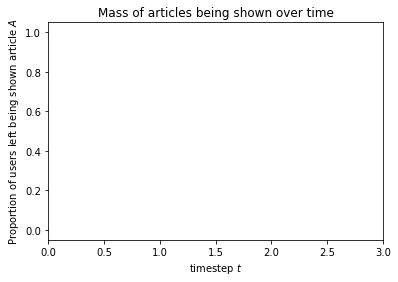

In [14]:
plt.plot(prob_article_A, color='black')
plt.title("Mass of articles being shown over time")
plt.ylabel("Proportion of users left being shown article $A$")
plt.xlabel("timestep $t$")
plt.ylim((-0.05,1.05))
plt.xlim((0,t))
plt.show()

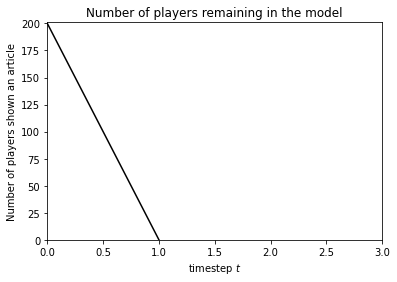

In [15]:
plt.plot(num_players_in_model, color='black')
plt.title("Number of players remaining in the model")
plt.ylabel("Number of players shown an article")
plt.xlabel("timestep $t$")
plt.xlim((0,t))
plt.ylim((0, m + 1))
plt.show()

C:\Users\jfino\anaconda3\lib\site-packages\numpy\lib\function_base.py:393: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\jfino\anaconda3\lib\site-packages\numpy\core\_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


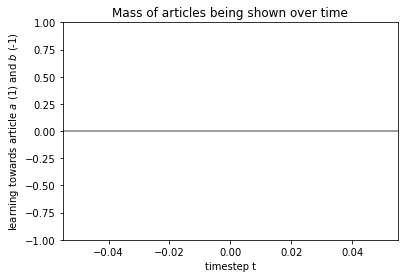

In [16]:
plt.plot(time_data_diff, color='black')
plt.title("Mass of articles being shown over time")
plt.ylabel("learning towards article $a$ (1) and $b$ (-1)")
plt.xlabel("timestep t")
plt.ylim((-1,1))
plt.axhline(y=0,color='grey')
plt.axhline(y=np.average(time_data_diff),color='blue')
#plt.axhline(y=epsilon,color='red')
#plt.axhline(y=-1 * epsilon,color='red')
plt.show()